In [1]:
#General settings
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob
sn.set_context('notebook')
import numpy as np
import pylab as pl
import statsmodels.api as sm
from IPython.display import Image

from read_parameters import loadPerformance, loadLimits, readMARS, saveDottyPlot
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

mpld3.enable_notebook()

warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')



Populating the interactive namespace from numpy and matplotlib


C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:94: DeprecationWarn

# Sensitivity and Uncertainty Analysis in streamflow at Langtjern using PERSiST

## Data and methods

Daily meteorological data (p,t) for the period 1982–2013 was used.

Daily streamflow at the "NE_Inlet" was used for model not validation.

First an overview of the discharge data at "NE_Inlet":

C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Users\JLG\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


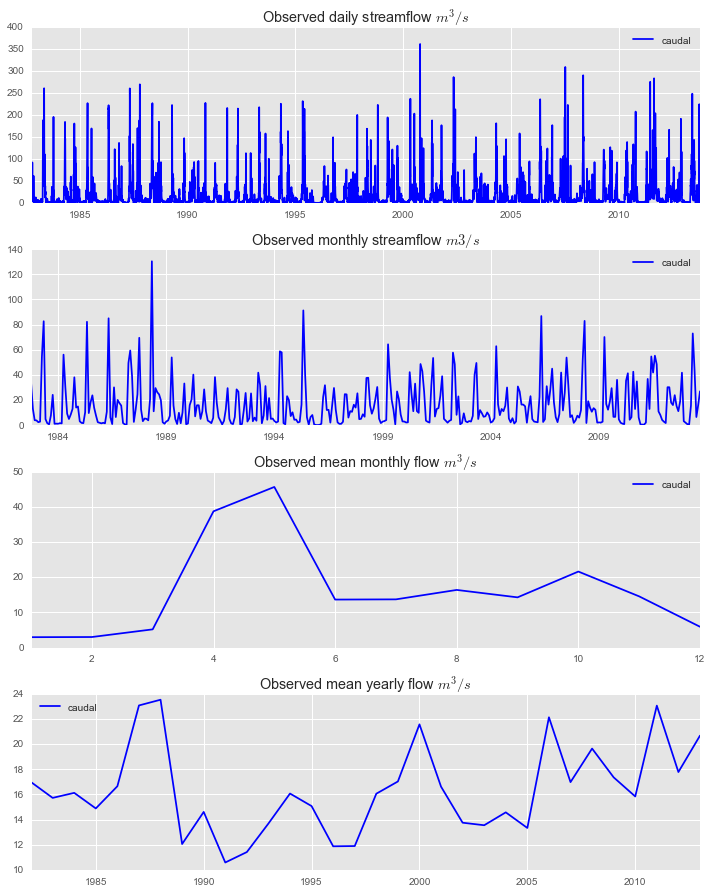

In [2]:
matplotlib.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (10, 12.5)

#Reading in flow data
flow_file=r"C:\Users\JLG\LJB_TestRun_Long\Ltj_inlet_1982-2013.obs"
flow_data = pd.read_csv(flow_file,'\t',header=1,nrows=11323,names=['fecha','caudal'],index_col='fecha')
flow_data.index = pd.date_range('10-01-1982', periods=11323, freq='D')
#print(flow_data.caudal)

rain_file=r"C:\Users\JLG\LJB_TestRun_Long\Ltj_gridded_1982-2013.dat"
rain_data = pd.read_csv(rain_file,'\t',header=2,nrows=11323,names=['p','t'])
rain_data.index = pd.date_range('10-01-1982', periods=11323, freq='D')
#print(rain_data.p)
    
flow_data.caudal = flow_data.caudal*1000    
#flow_data=flow_data['1989/1/1':]    

fig, ax = plt.subplots(nrows=4)

#Plotting the daily data
flow_data.plot(title='Observed daily streamflow $m^3/s$',ax=ax[0],color='blue')

#Plotting monthly data
monthly_flow = flow_data.resample('M').mean()
monthly_flow.plot(title='Observed monthly streamflow $m3/s$',ax=ax[1],color='blue')

#Plotting average monthly data
monthly_mean = flow_data.groupby(flow_data.index.month).aggregate(np.mean)
monthly_mean.plot(title='Observed mean monthly flow $m^3/s$',ax=ax[2],color='blue')

#Plotting average yearly data
yearly_mean = flow_data.resample('A').mean()
yearly_mean.plot(title='Observed mean yearly flow $m^3/s$',ax=ax[3],color='blue')

plt.tight_layout()

plt.show()

There seems to be a trend in the discharge data. Let's check if it is significant, but excluding the first year of data since it is incomplete:

                            OLS Regression Results                            
Dep. Variable:                 caudal   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.052
Date:                Tue, 23 Aug 2016   Prob (F-statistic):              0.163
Time:                        09:00:04   Log-Likelihood:                -82.333
No. Observations:                  31   AIC:                             168.7
Df Residuals:                      29   BIC:                             171.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         14.7186      1.311     11.226      0.0

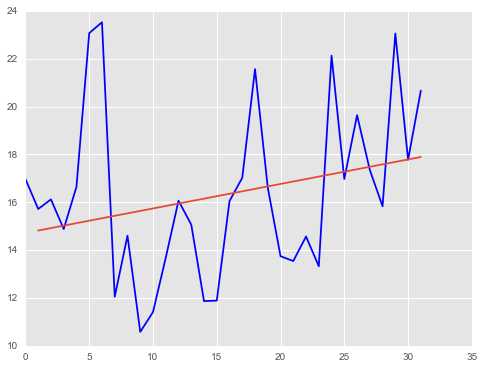

In [3]:
x = np.arange(yearly_mean.count())
X = sm.add_constant(x)
y = yearly_mean['caudal']
res = sm.OLS(y[1:],X[1:]).fit()
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'b-', label="Yearly average streamflow")
ax.plot(x[1:], res.fittedvalues, label="Linear fit")

print(res.summary())

There does not appear to be a trend in the yearly data. 
There appears to be, however, a change in the data in 1989.
If we repeat the trend analysis for that period:


                            OLS Regression Results                            
Dep. Variable:                 caudal   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     15.20
Date:                Mon, 22 Aug 2016   Prob (F-statistic):           0.000771
Time:                        11:22:10   Log-Likelihood:                -56.963
No. Observations:                  24   AIC:                             117.9
Df Residuals:                      22   BIC:                             120.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         12.1457      1.143     10.625      0.0

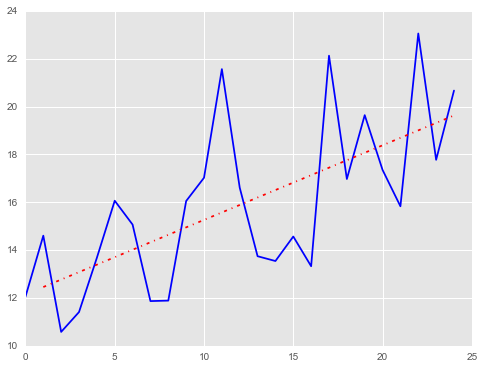

In [13]:
subset_1989 = flow_data['1989/1/1':]
subset_1989_Y = subset_1989.resample('A').mean()
x = np.arange(subset_1989_Y.count())
X = sm.add_constant(x)
y = subset_1989_Y['caudal']
res = sm.OLS(y[1:],X[1:]).fit()
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'b-', label="Yearly average streamflow")
ax.plot(x[1:], res.fittedvalues, 'r-.', label="Linear fit")

subset_1983_Y = flow_data['1983/1/1':'1988/12/31'].resample('A').mean()

print(res.summary())
print(stats.ks_2samp(subset_1983_Y.caudal,subset_1989_Y.caudal))

And in this case the trend appears to be significant. This could point to:

1. Changes in how the data was measured
2. Changes in the catchment
3. Changes in the climate.

It should be noted, however that performing the Kolmogorov-Smirnov test on the two periods pre and post 1989, one cannot reject the hypothesis that the samples come from the same distribution. 

### Methods: GLUE

GLUE is a global sensitivity analysis and uncertainty evaluation method that, at its most basic, randomly sample parameters values within predefined ranges and computes a performance measure for the different parameter values combinations, that allows ranking the different parameter combination and compute uncertainty bounds from these rankings. 

The results depend primarily on the objective function, a measure of the goodness of fit between observed and simulated discharge and the behevioral threshold, a measure beyond which the fit is considered "good enough".

The PERSiST hydrological model was used to simulate discharge. A problem for the application of GLUE and other sensitivity analysis methods is that the computational requirements grow exponentially with the dimensionality of the problem.

Here is a list of the free parameters in the PERSiST setup at Langtjern, with their sampling range:



In [5]:
(names,values) = loadPerformance(r'C:\Users\JLG\LJB_TestRun_Long\results\behavioralParameters_NSE_smooth.txt')
for word in names:
    print(word)

['groundwater', 'Time_constant']
['soil_water', 'Time_constant']
['soil_water', 'Retained_water_depth']
['square_matrix', 'BFI']
['snow', 'Degree_day_ETP']
['snow', 'Rain_multiplier']
['snow', 'Degree_day_melt']
['snow', 'Melt_temperature']
['snow', 'Snow_multiplier']


### Methods: Sensitivity analysis with PSUADE

PSUADE is a freely available library that provides an array of sensitivity analysis methods. Here we test a few of them.
In a similar fashion to GLUE, the number of free parameters is a limitation which is exacerbated by numerical instabilities.
Some of these methods rely on matrix operations. The size of said matrices is proportional to the number of parameters and the stability issues are only worsened in the presence of correlations between parameters, something unavoidable in overparameterized models.

Both GLUE and PSUADE are implemented in C++ and we present here a postprocessing of the data.

## Results: GLUE

The GLUE analysis was run for the period 1982-2023. The model was run for the period 1973-2013

The GLUE implementation provides an array of possible objective functions. Let us start showing the classic Nash-Sutcliffe efficiency using "dotty plots" and the 5% and 95% uncertainty bounds for the discharge.

The dotty plots show parameter values in the x-axis and the performance on the y-axis. Each dot is the performance for a certain parameter-value combinations (one random value for each of the parameters listed above).







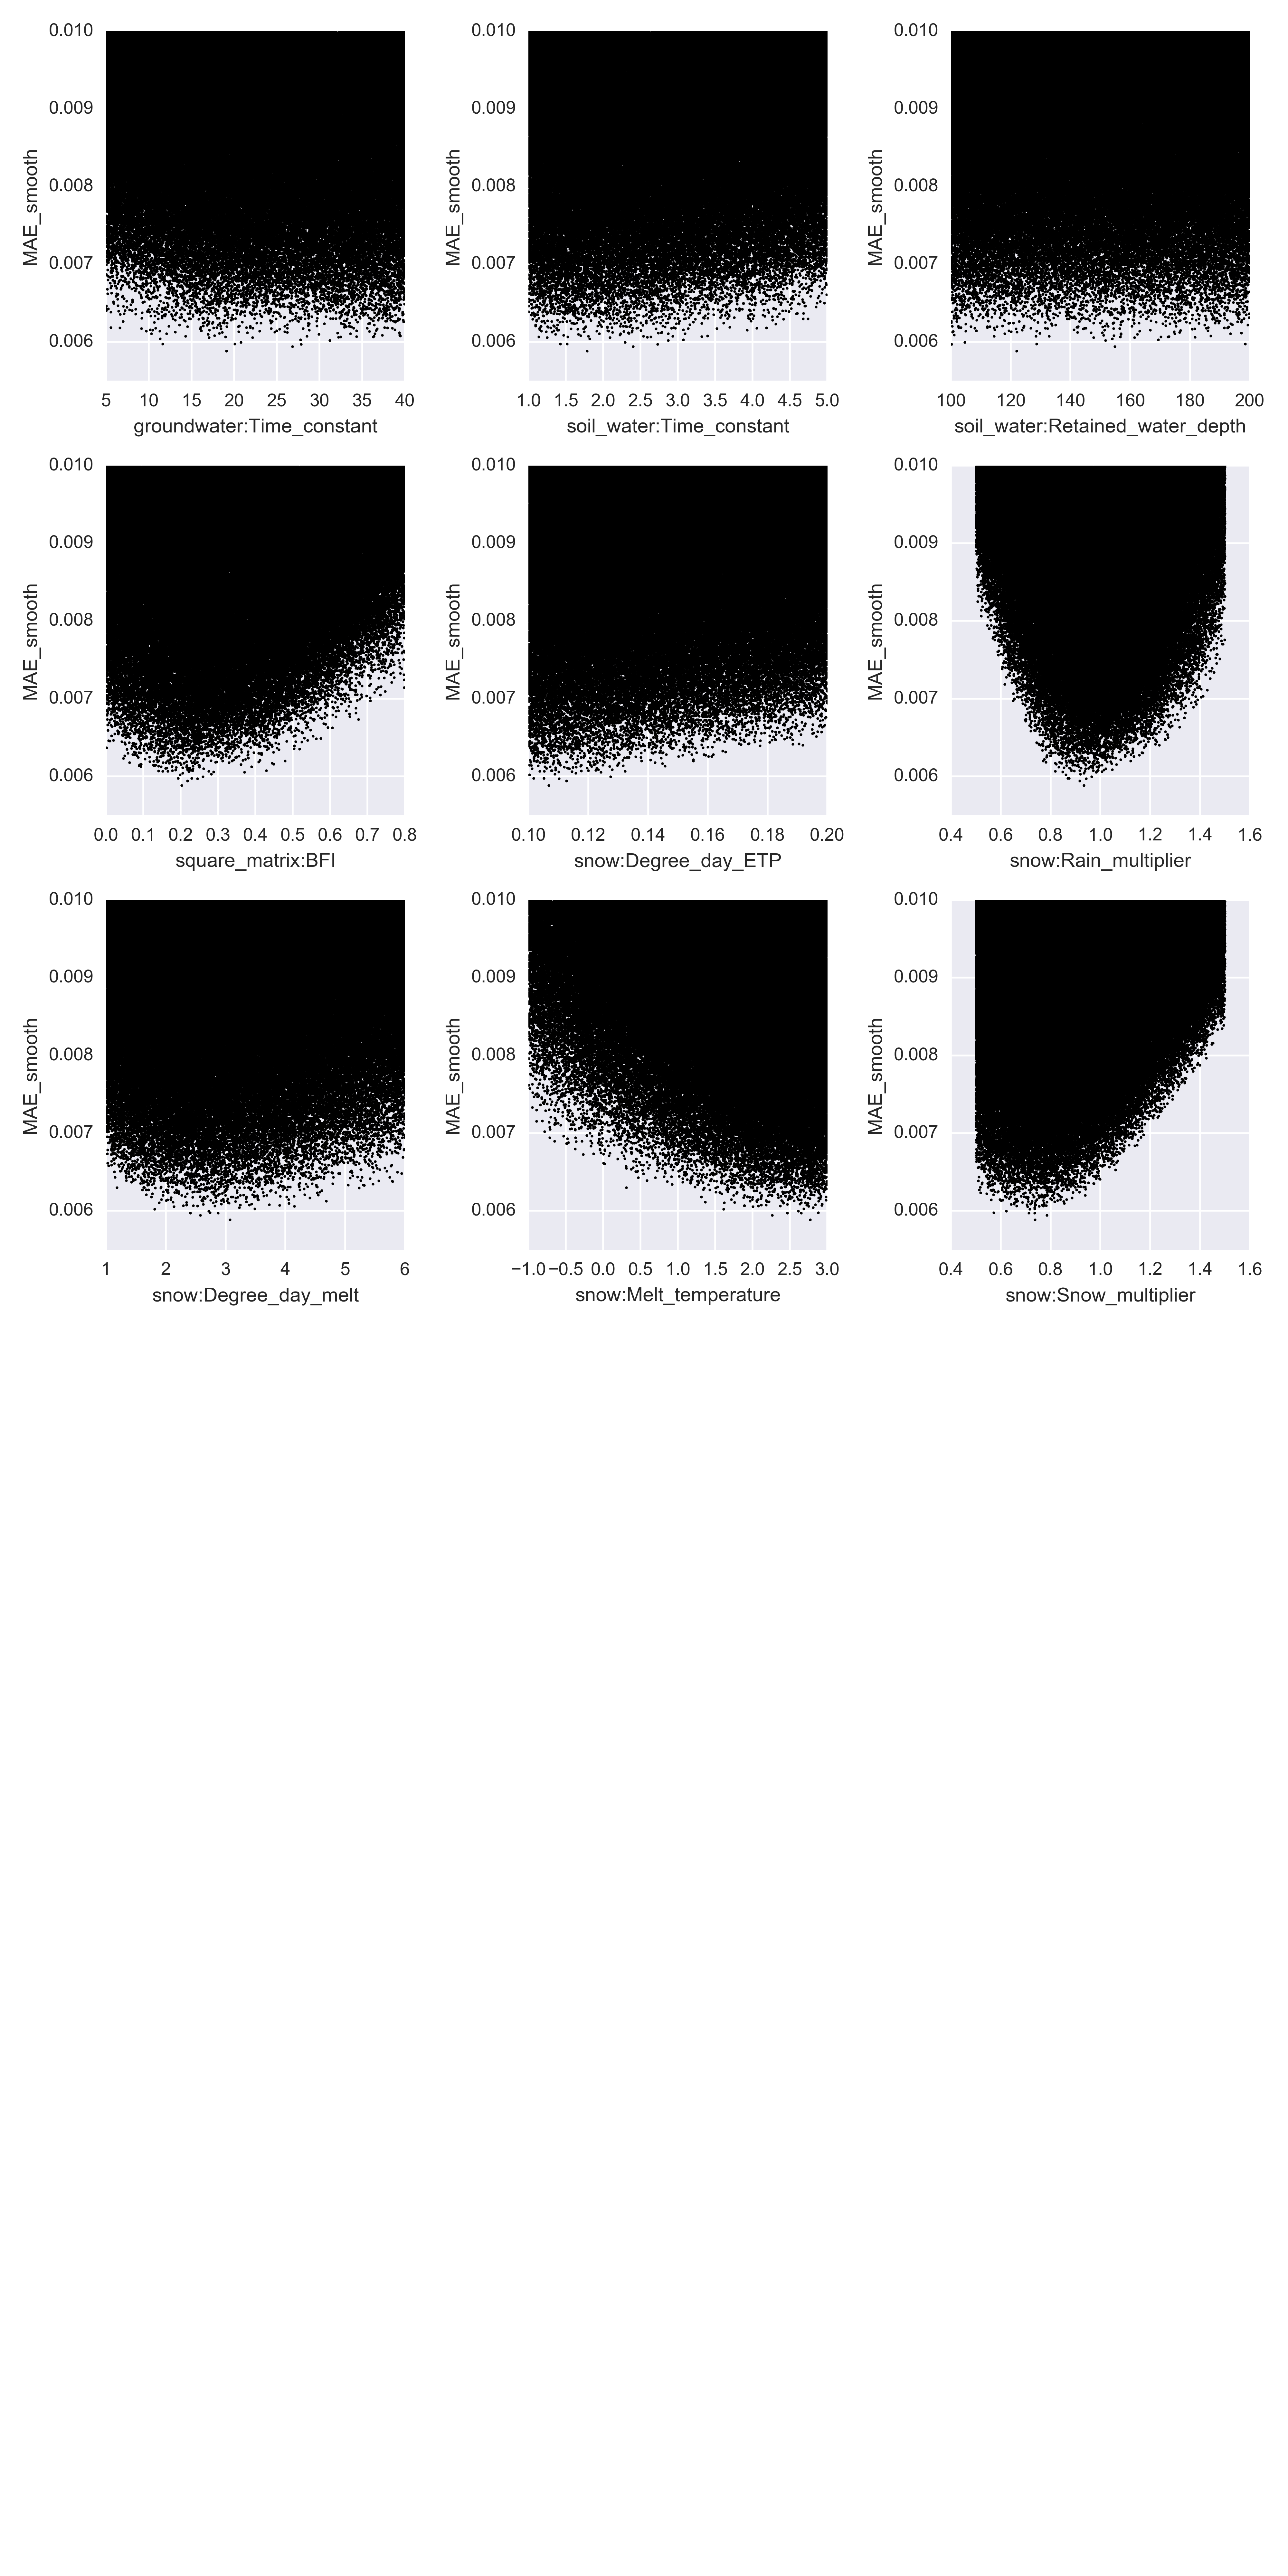

In [3]:
pathStr = r"C:\\Users\\JLG\\LJB_TestRun_Long\\results\\"
objFunStr = "MAE_smooth"
imgFmtStr = ".png"
saveDottyPlot(pathStr,objFunStr,imgFmtStr)
Image(objFunStr + imgFmtStr)


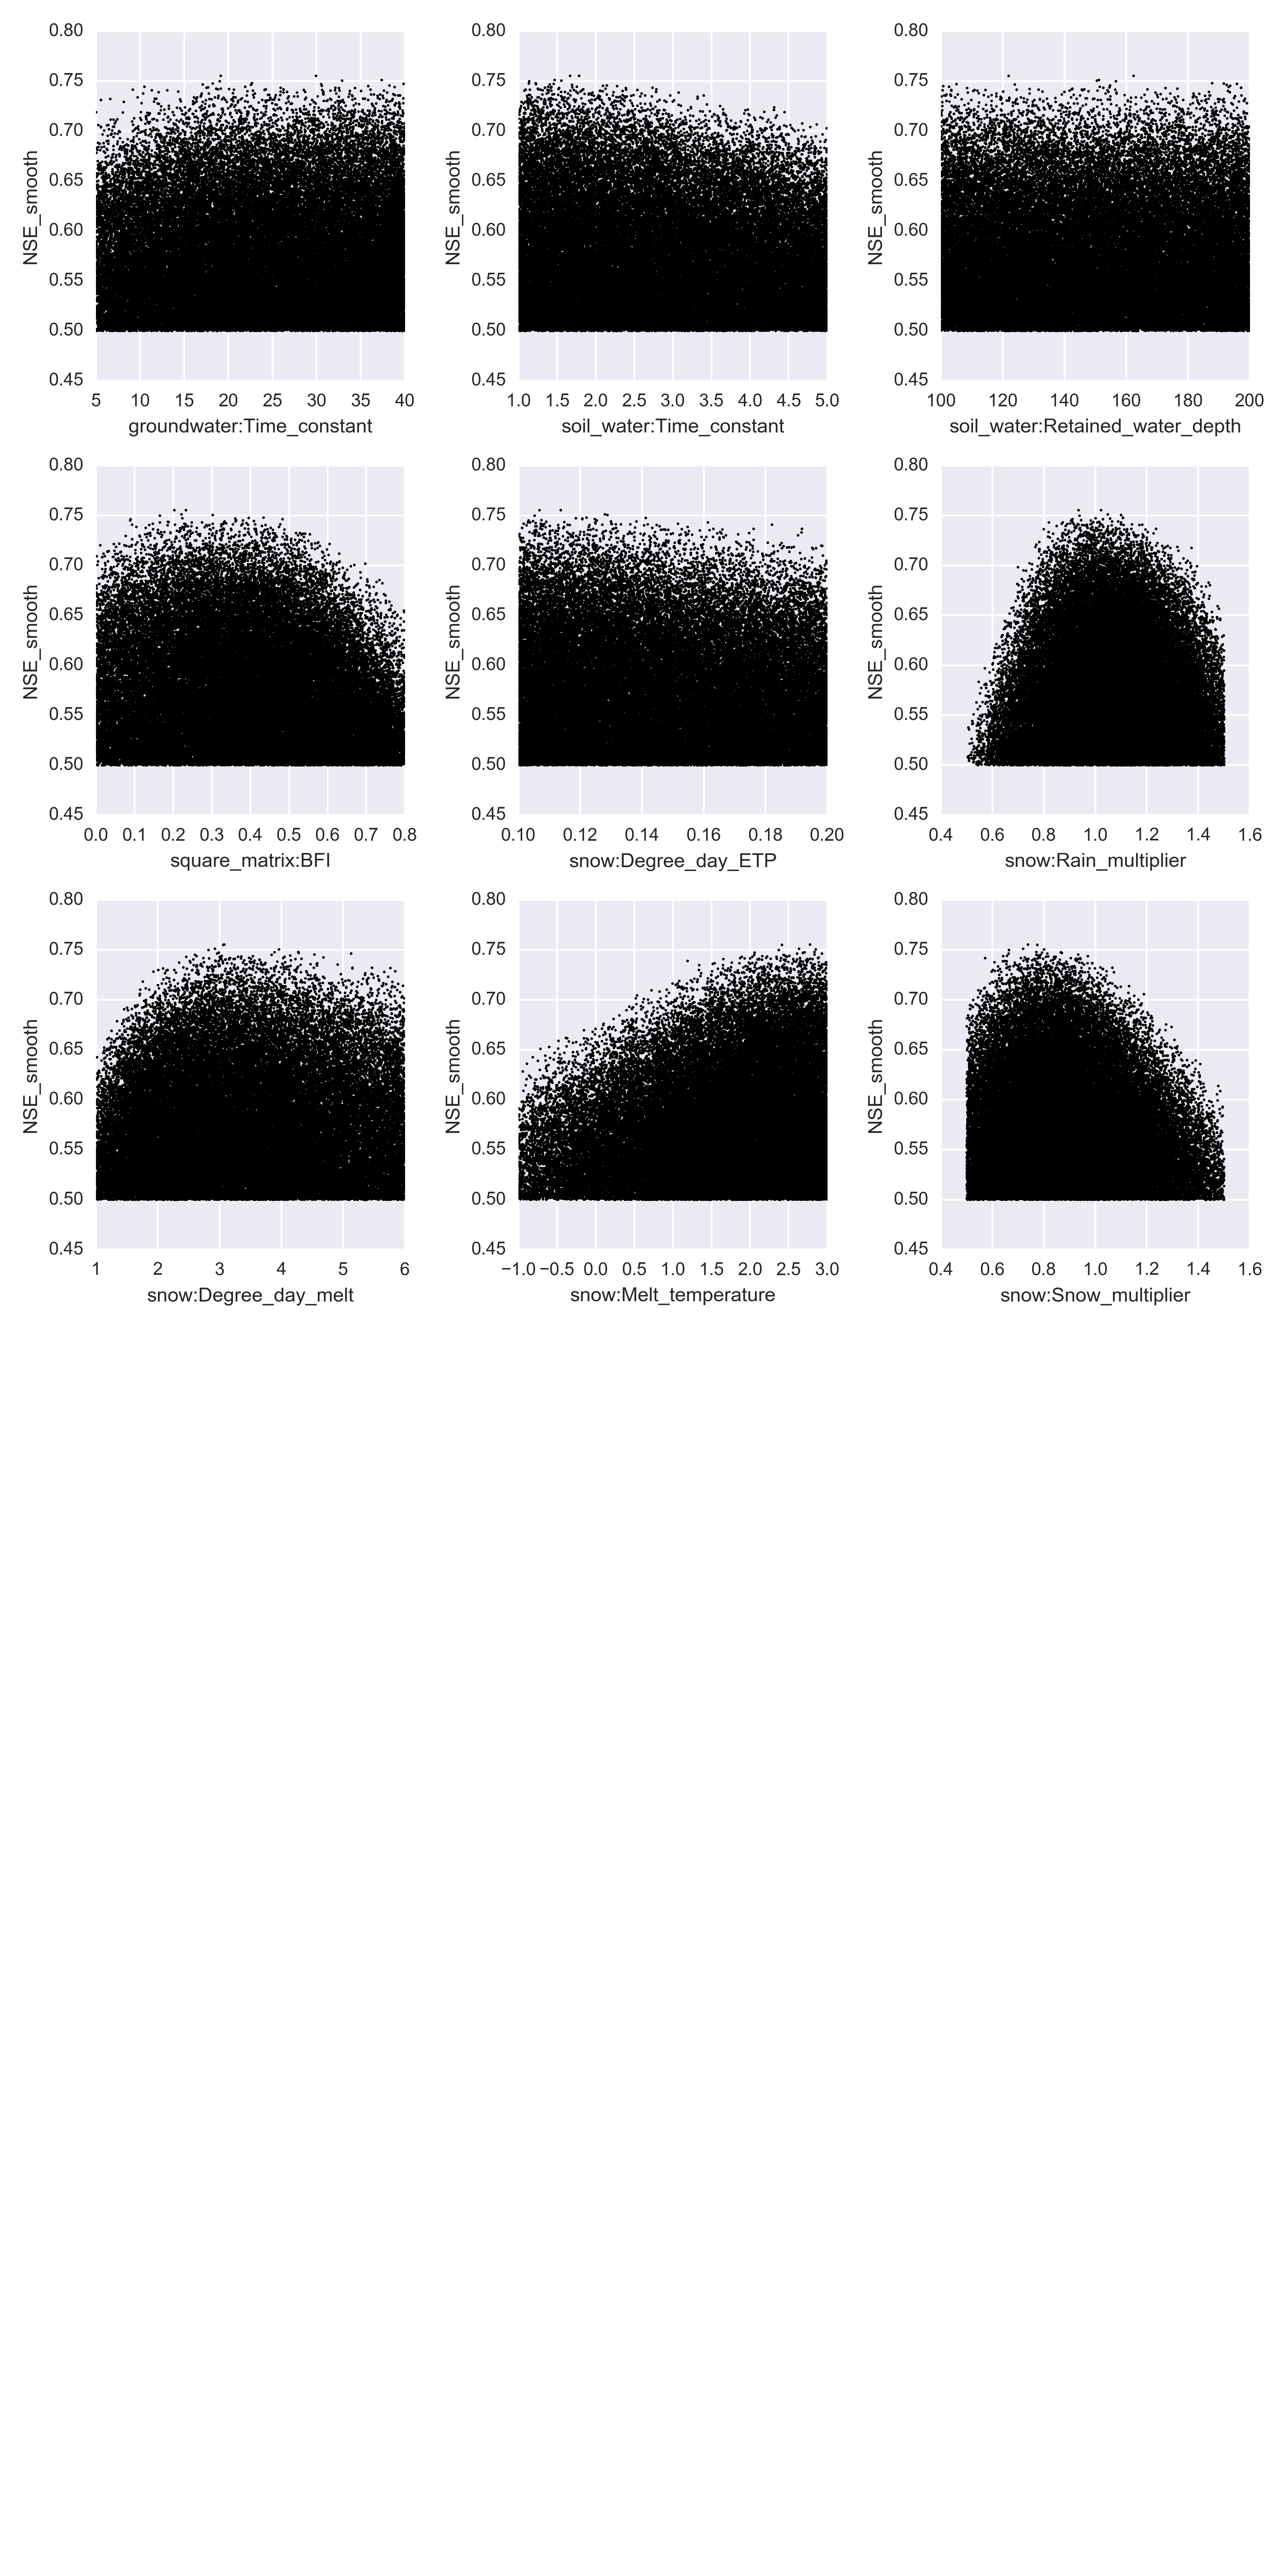

In [4]:
objFunStr = "NSE_smooth"
saveDottyPlot(pathStr,objFunStr,imgFmtStr)
Image(objFunStr + imgFmtStr)

In [8]:
bounds = loadLimits(r"C:\Users\JLG\LJB_TestRun_Long\results\Uncertainty_bounds.txt")
bounds = bounds.multiply(1000)

w_start = '1985/1/1'
w_end =  '1986/12/31'

fig, ax = plt.subplots(2, sharex=True)
pylab.rcParams['figure.figsize'] = (7.5,15)

ax[1].plot(flow_data[w_start:w_end].index,flow_data[w_start:w_end].caudal,'b-')
sub = bounds[w_start:w_end]
ax[1].fill_between(sub.index,sub['quant:0.025'],sub['quant:0.975'],facecolor='grey',edgecolor='none')

temp=rain_data[w_start:w_end]
ax[0].bar(temp.index,temp['p'],color='blue',edgecolor='none')
ax[0].get_xaxis().set_ticks([])
ax[0].invert_yaxis()
ax[0].yaxis.tick_right()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\JLG\\LJB_TestRun_Long\\results\\Uncertainty_bounds.txt'

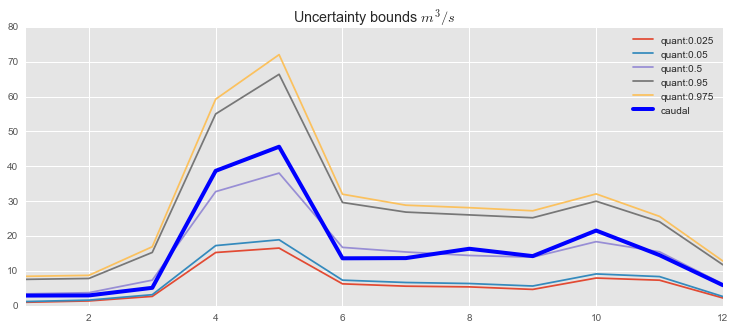

In [20]:
#Plotting uncertain mean
#figure()
pylab.rcParams['figure.figsize'] = (12.5, 5)
uncertain_month = bounds.groupby(bounds.index.month).aggregate(np.mean)
observed_q_month = flow_data['1982/1/1':'2013/12/31'].groupby(flow_data['1982/1/1':'2013/12/31'].index.month).aggregate(np.mean)
ax=uncertain_month.plot(title='Uncertainty bounds $m^3/s$')
observed_q_month.plot(ax=ax,color='blue',LineWidth=4)
plt.show()

We can see that there is a rater stark difference for the streamflow when using different objective functions.

In [ ]:
uncertain_month_MME = loadLimits('Behavioral_limits_MME100k.txt')
uncertain_month_NSE = loadLimits('Behavioral_limits_NSE100k.txt')
uncertain_month_MME = uncertain_month_MME.groupby(uncertain_month_MME.index.month).aggregate(np.mean)*1000
uncertain_month_NSE = uncertain_month_NSE.groupby(uncertain_month_NSE.index.month).aggregate(np.mean)*1000
#figure()
pylab.rcParams['figure.figsize'] = (12.5, 5)
ax = observed_q_month.plot(color='blue',LineWidth=4)
ax.fill_between(uncertain_month_MME.index,uncertain_month_MME['quant:0.025'],uncertain_month_MME['quant:0.975'],alpha=0.75,color='grey',label='MME')
ax.fill_between(uncertain_month_NSE.index,uncertain_month_NSE['quant:0.025'],uncertain_month_NSE['quant:0.975'],alpha=0.25,color='red',label='NSE')
pl.show()

## Results: Sensitivity Analysis

Let's look at different sentivity analyis methods and their 
results

### MARS

Multi-adaptive regression splines. Response surface fitting, provides relative rankings.

In [ ]:
(num,rank) = readMARS('MARS.txt')
print(rank)
pylab.rcParams['figure.figsize'] = (12.5, 5)
plt.bar(num,rank)